In [30]:
#Importando as blibliotecas necessarias
import pandas as pd
import pyodbc
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
def isValidDate(input):
    """
    Verifica se uma string está no formato de data esperado.

    Parâmetros:
    - input (str): A string que representa uma data.

    Retorno:
    - True se a string estiver no formato de data especificado, False caso contrário.
    """
    format = "%m/%d/%Y"
    try:
            return bool(datetime.strptime(input, format))
    except ValueError:
        return False

def isFloat(input):
    """
    Verifica se uma string pode ser convertida para um número de ponto flutuante.

    Parâmetros:
    - input (str): A string que se deseja verificar se é um número de ponto flutuante.

    Retorno:
    - True se a string puder ser convertida para um número de ponto flutuante, False caso contrário.
    """
    try:
        float(input)
        return True
    except ValueError:
        return False

def cleanAndFormatDate(input):
    """
    Converte e formata uma string para o formato de data desejado, se necessário.

    Parâmetros:
    - input (str): A string que representa uma data.

    Retorno:
    - A data formatada (str) se estiver no formato correto; caso contrário, converte e formata a data conforme especificado.
    """
    if not isValidDate(str(input)):
        return (datetime(1899, 12, 30) + timedelta(days=int(input))).strftime("%m/%d/%Y")
    else:
        return input

def cleanAndFormatFloat(input):
    """
    Converte e formata uma string para um número de ponto flutuante, se necessário.

    Parâmetros:
    - input (str): A string que representa um número de ponto flutuante.

    Retorno:
    - O número de ponto flutuante se a string estiver no formato correto; caso contrário, converte e formata o número de ponto flutuante conforme especificado.
    """
    if not isFloat(input):
        return round(float(input.replace('"', '').replace(',', '.')), 2)
    else:
        return input

In [32]:
#Variaveis de acesso ao banco de dados
server = ''
database = ''
username = ''
password = ''

In [33]:
#Criando a engine de conexão com o banco de dados e definindo o nome da tabela
database_url = 'mssql+pyodbc://' + username + ':' + password + '@' + server + '/' + database + '?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(database_url)
table_name = 'Orders'

In [34]:
# Diretório contendo os arquivos
dir = './Data/'

# Lista de arquivos no diretório
files = [f for f in listdir(dir) if isfile(join(dir, f))]

# Loop através de cada arquivo no diretório
for file in files:
    # Leitura do arquivo CSV para um DataFrame
    df = pd.read_csv(dir + file)

    # Renomeando as colunas do DataFrame
    df.columns = ['order_id', 'delivery_date', 'shop_name', 'amount']

    # Aplicação da função cleanAndFormatDate para formatar a coluna 'delivery_date'
    df['delivery_date'] = df['delivery_date'].apply(lambda x: cleanAndFormatDate(x))

    # Aplicação da função cleanAndFormatFloat para formatar a coluna 'amount'
    df['amount'] = df['amount'].apply(lambda x: cleanAndFormatFloat(x)) 

    # Gravação do DataFrame no banco de dados usando SQLAlchemy
    df.to_sql(name=table_name, con=engine, if_exists='append', index=False)

In [35]:
# Consulta SQL para obter estatísticas gerais de pedidos
sql_query_total = """
    SELECT 'TotalOrders' as Item, COUNT(order_id) as [Value] FROM Orders
    UNION ALL
    SELECT 'DistinctOrders' as Item, COUNT(DISTINCT order_id) as [Value] FROM Orders
    UNION ALL
    SELECT 'TotalAmount' as Item, ROUND(SUM(amount), 2) [Value] FROM Orders
"""

# Execução da consulta e leitura dos resultados para um DataFrame
items = pd.read_sql_query(sql_query_total, engine)

# Consulta SQL para obter o total de valores por data de entrega
sql_query_total_amount = "SELECT delivery_date, ROUND(SUM(amount), 2) AS Total FROM Orders GROUP BY delivery_date ORDER BY delivery_date;"

# Execução da consulta e leitura dos resultados para um DataFrame
total_amount_per_delivery_date = pd.read_sql_query(sql_query_total_amount, engine)


In [36]:
#Exibindo os resultados
print('--------Items 2a, 2b, 2c--------')
print(items)
print()
print('-------------Item 2d------------')
print(total_amount_per_delivery_date)

--------Items 2a, 2b, 2c--------
             Item    Value
0     TotalOrders   210.00
1  DistinctOrders    98.00
2     TotalAmount  6364.26

-------------Item 2d------------
  delivery_date    Total
0    2022-01-01  1251.98
1    2022-01-02   933.30
2    2022-01-03   864.94
3    2022-01-04   997.98
4    2022-01-05   907.34
5    2022-02-01   506.02
6    2022-03-01   370.76
7    2022-04-01   222.30
8    2022-05-01   309.64


In [37]:
#Obtendo todos os dados da tabela
sql_query = 'select order_id, delivery_date, shop_name, amount from Orders'
df_table = pd.read_sql_query(sql_query, engine)

engine.dispose()

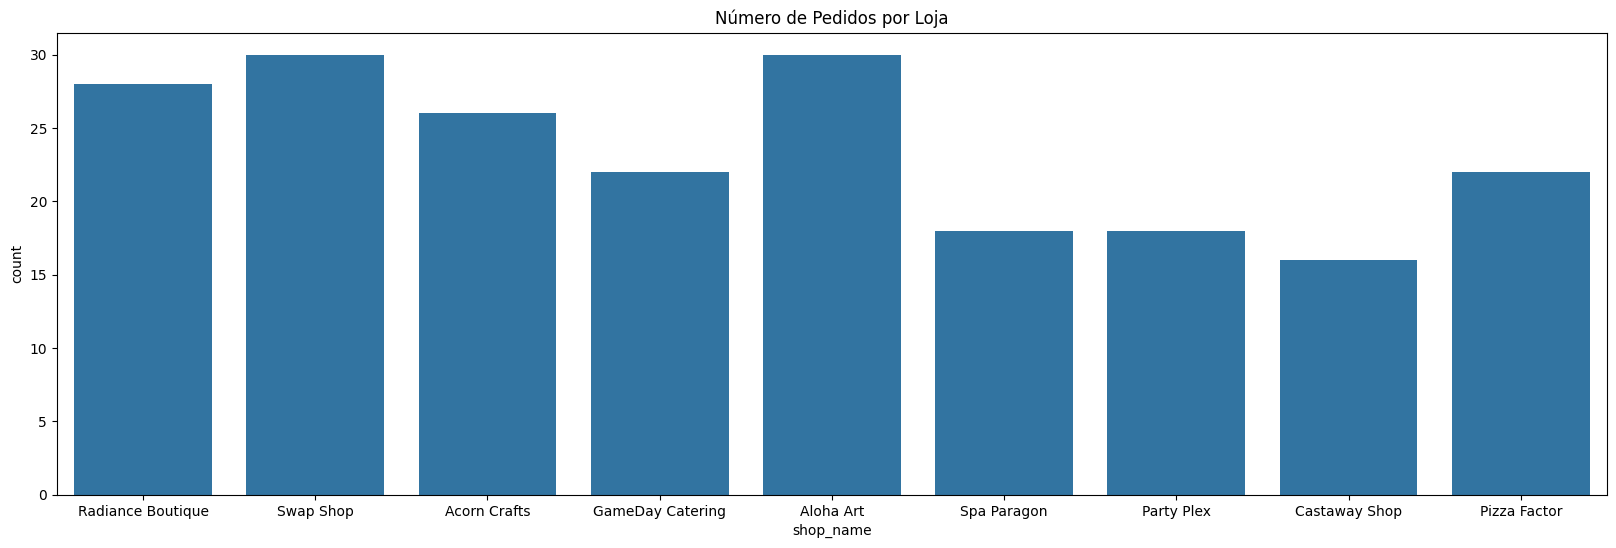

In [38]:
#Grafico de barras exibindo o numero de pedidos por loja
plt.figure(figsize=(20, 6))
sns.countplot(x='shop_name', data=df_table)
plt.title('Número de Pedidos por Loja')
plt.show()

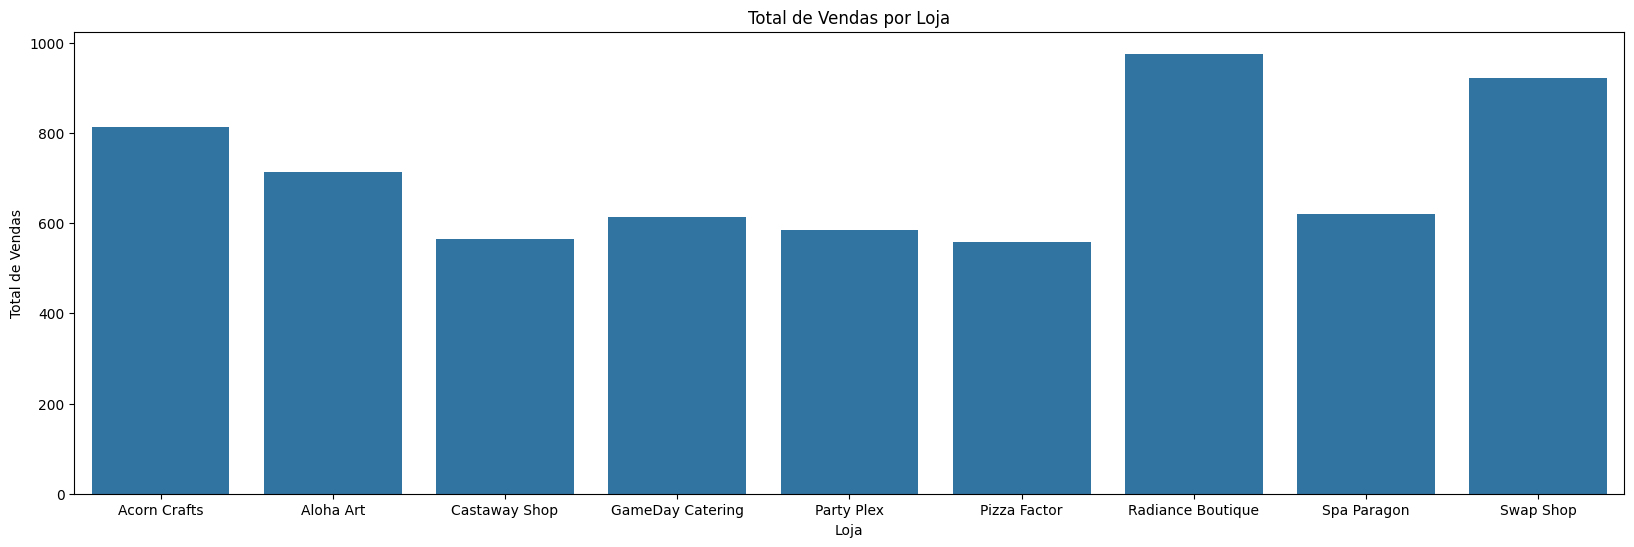

In [39]:
#Grafico de barras exibindo o valor total de pedidos por loja
total_vendas_por_loja = df_table.groupby('shop_name')['amount'].sum().reset_index()

# Gráfico de barras
plt.figure(figsize=(20, 6))
sns.barplot(x='shop_name', y='amount', data=total_vendas_por_loja)
plt.title('Total de Vendas por Loja')
plt.xlabel('Loja')
plt.ylabel('Total de Vendas')
plt.show()

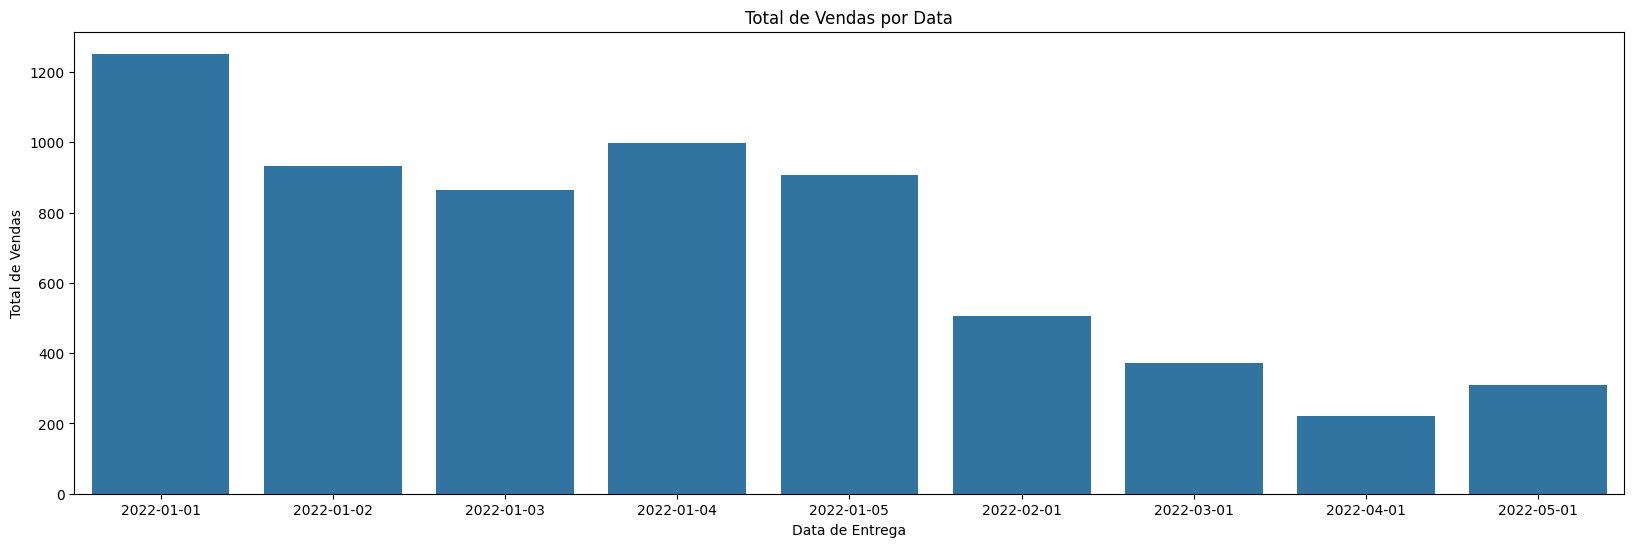

In [40]:
#Grafico de barras exibindo o valor total de pedidos por data de entrega
total_vendas_por_data = df_table.groupby('delivery_date')['amount'].sum().reset_index()

# Gráfico de barras
plt.figure(figsize=(20, 6))
sns.barplot(x='delivery_date', y='amount', data=total_vendas_por_data)
plt.title('Total de Vendas por Data')
plt.xlabel('Data de Entrega')
plt.ylabel('Total de Vendas')
plt.show()